### All Rights Reserved. This notebook is proprietary content of machinelearningplus.com. This can be shared solely for educational purposes, with due credits to machinelearningplus.com

<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#5d3a8e; font-size:40px'> Topic Modeling with Gensim (Python)</h1>
</div>

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is *how to extract good quality of topics that are clear, segregated and meaningful.* This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Content</h2>
</div>

1. Introduction
2. Prerequisites – Download nltk stopwords and spacy model
3. Import Packages
4. What does LDA do?
5. Prepare Stopwords
6. Import Newsgroups Data
7. Remove emails and newline characters
8. Tokenize words and Clean-up text
9. Creating Bigram and Trigram Models
10. Remove Stopwords, Make Bigrams and Lemmatize
11. Create the Dictionary and Corpus needed for Topic Modeling
12. Building the Topic Model
13. View the topics in LDA model
14. Compute Model Perplexity and Coherence Score
15. Visualize the topics-keywords
16. Building LDA Mallet Model
17. How to find the optimal number of topics for LDA?
18. Finding the dominant topic in each sentence
19. Find the most representative document for each topic
20. Topic distribution across documents

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 1. Introduction</h2>
</div>

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

Let’s begin!
Topic Modeling with Gensim in Python. Photo by Jeremy Bishop.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Prerequisites – Download nltk stopwords and spacy model</h2>
</div>

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joaquingomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Import Packages</h2>
</div>

The core packages used in this tutorial are `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`,`numpy` and `pandas` for data handling and visualization. Let’s import them.

In [2]:
# pip install pyLDAvis
# pip install gensim
# pip install spacy==2.2.0

In [15]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4. What does LDA do?</h2>
</div>

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:


1)The quality of text processing.

2)The variety of topics the text talks about.

3)The choice of topic modeling algorithm.

4)The number of topics fed to the algorithm.

5)The algorithms tuning parameters.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Prepare Stopwords</h2>
</div>


We have already downloaded the stopwords. Let's import them and make it available in `stop_words`.

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. Import Newsgroups Data</h2>
</div>

We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as [newsgroups.json](https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json).

This is imported using `pandas.read_json` and the resulting dataset has 3 columns as shown.

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


content  target  \
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4   
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1   
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14   

            target_names  
0              rec.autos  
1  comp.sys.mac.hardware  
2  comp.sys.mac.hardware  
3          comp.graphics  
4              sci.space

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Remove emails and newline characters</h2>
</div>

As you can see there are many emails, newline and extra spaces that is quite distracting. Let's get rid of them using [regular expressions](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/).

In [6]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['From: (where s my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ',
 'From: (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for '
 'SI clock reports Keywords: SI,acceleration,clock,upgrade Article-I.D.: '
 'shelley.1qvfo9INNc3s Organization: University of Washington Lines: 11 '
 'NNTP-Posting-Host: carson.u.washingto

In [22]:
data

['From: (where s my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ',
 'From: (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for SI clock reports Keywords: SI,acceleration,clock,upgrade Article-I.D.: shelley.1qvfo9INNc3s Organization: University of Washington Lines: 11 NNTP-Posting-Host: carson.u.washington.edu A fair number of brave souls who upgraded 

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Tokenize words and Clean-up text </h2>
</div>

The sentences look better now, but you want to tokenize each sentence into a list of words, removing punctuations and unneccessary characters altogether.

Gensim's `simple_preprocess()` is great for this. Additionally I have set `deacc=True` to remove the punctuations.

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])


[['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [24]:
df = pd.read_csv('/Users/joaquingomez/Downloads/dataset/full_dataset.csv')

In [25]:
directions_list = df['directions'].to_list()

In [30]:
from random import sample

In [31]:
directions_sample = sample(directions_list,10000)

In [34]:
directions_words = list(sent_to_words(directions_sample))
print(directions_words[:1])

[['heat', 'oil', 'in', 'large', 'nonstick', 'skillet', 'over', 'medium', 'heat', 'add', 'prechopped', 'onion', 'cook', 'minutes', 'or', 'until', 'tender', 'stirring', 'frequently', 'stir', 'in', 'cumin', 'chili', 'powder', 'garlic', 'salt', 'and', 'pepper', 'cook', 'minute', 'stir', 'in', 'beans', 'cook', 'minutes', 'remove', 'from', 'heat', 'add', 'chicken', 'cup', 'green', 'onions', 'and', 'tablespoons', 'ripe', 'olives', 'stir', 'well', 'preheat', 'oven', 'to', 'layer', 'tortillas', 'on', 'bottom', 'of', 'inch', 'baking', 'dish', 'coated', 'with', 'cooking', 'spray', 'spread', 'cups', 'chicken', 'mixture', 'over', 'tortillas', 'sprinkle', 'with', 'cup', 'cheese', 'repeat', 'layers', 'once', 'top', 'with', 'remaining', 'tortillas', 'combine', 'milk', 'chopped', 'cilantro', 'and', 'salsa', 'in', 'blender', 'and', 'process', 'until', 'smooth', 'pour', 'over', 'top', 'of', 'tortillas', 'cover', 'and', 'bake', 'at', 'for', 'minutes', 'uncover', 'sprinkle', 'with', 'remaining', 'cup', 'ch

In [26]:
directions_list

['["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]',
 '["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\u00b0 for 3 hours."]',
 '["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]',
 '["Boil and debone chicken.", "Put bite size pieces in average size square casserole dish.", "Pour gravy and cream of mushroom soup over chicken; level.", "Make stuffing according to instructions on box (do not make too moist).", "Put stuffing on top of chicken and gravy; level."

In [23]:
data_words

[['from',
  'where',
  'my',
  'thing',
  'subject',
  'what',
  'car',
  'is',
  'this',
  'nntp',
  'posting',
  'host',
  'rac',
  'wam',
  'umd',
  'edu',
  'organization',
  'university',
  'of',
  'maryland',
  'college',
  'park',
  'lines',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'saw',
  'the',
  'other',
  'day',
  'it',
  'was',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  'early',
  'it',
  'was',
  'called',
  'bricklin',
  'the',
  'doors',
  'were',
  'really',
  'small',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  'this',
  'is',
  'all',
  'know',
  'if',
  'anyone',
  'can',
  'tellme',
  'model',
  'name',
  'engine',
  'specs',
  'years',
  'of',
  'production',
  'where',
  'this',
  'car',
  'is',
  'made',
  'history',
  'or',
  'whatever',
  '

In [9]:
type(data_words)

list

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Create Bigram and Trigram Models</h2>
</div>

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: 'front bumper', 'oil leak', 'maryland college park' etc.

Gensim's `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [35]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(directions_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[directions_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[directions_words[0]]])

['heat', 'oil', 'in', 'large', 'nonstick', 'skillet', 'over', 'medium', 'heat', 'add', 'prechopped', 'onion', 'cook', 'minutes', 'or', 'until', 'tender', 'stirring', 'frequently', 'stir', 'in', 'cumin', 'chili', 'powder', 'garlic', 'salt', 'and', 'pepper', 'cook', 'minute', 'stir', 'in', 'beans', 'cook', 'minutes', 'remove', 'from', 'heat', 'add', 'chicken', 'cup', 'green', 'onions', 'and', 'tablespoons', 'ripe', 'olives', 'stir', 'well', 'preheat', 'oven', 'to', 'layer', 'tortillas', 'on', 'bottom', 'of', 'inch', 'baking', 'dish', 'coated', 'with', 'cooking', 'spray', 'spread', 'cups', 'chicken', 'mixture', 'over', 'tortillas', 'sprinkle', 'with', 'cup', 'cheese', 'repeat', 'layers', 'once', 'top', 'with', 'remaining', 'tortillas', 'combine', 'milk', 'chopped', 'cilantro', 'and', 'salsa', 'in', 'blender', 'and', 'process', 'until', 'smooth', 'pour', 'over', 'top', 'of', 'tortillas', 'cover', 'and', 'bake', 'at', 'for', 'minutes', 'uncover', 'sprinkle', 'with', 'remaining', 'cup', 'che

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Remove Stopwords, Make Bigrams and Lemmatize</h2>
</div>


The bigrams model is ready. Let's define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [10]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [37]:
# Remove Stop Words
directions_words_nostops = remove_stopwords(directions_words)

# Form Bigrams
directions_words_bigrams = make_bigrams(directions_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
directions_lemmatized = lemmatization(directions_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(directions_lemmatized[:1])

[['heat', 'large', 'nonstick', 'heat', 'add', 'prechoppe', 'onion', 'cook', 'minute', 'tender', 'stirring', 'frequently', 'stir', 'cumin', 'chili', 'powder', 'garlic', 'salt', 'pepper', 'cook', 'stir', 'bean', 'cook', 'minute', 'remove', 'heat', 'add', 'cup', 'green', 'onion', 'tablespoon', 'ripe', 'olive', 'stir', 'well', 'preheat', 'oven', 'bottom', 'inch', 'bake', 'dish', 'coated', 'cooking', 'spray', 'spread', 'cup', 'chicken', 'mixture', 'tortilla', 'sprinkle', 'cup', 'cheese', 'repeat', 'layer', 'top', 'remain', 'tortilla', 'combine', 'milk', 'chop', 'blender', 'process', 'pour', 'top', 'tortillas', 'bake', 'minute', 'uncover', 'sprinkle', 'remain', 'cup', 'cheese', 'remain', 'cup', 'green', 'onion', 'remain', 'tablespoon', 'olive', 'bake', 'minute', 'cheese', 'melt', 'serve', 'sour', 'cream', 'garnish', 'sprig', 'desire']]


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Create the Dictionary and Corpus needed for Topic Modeling</h2>
</div>

The two main inputs to the LDA topic model are the dictionary(`id2word`) and the corpus. Let's create them.

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(directions_lemmatized)

# Create Corpus
texts = directions_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 3), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 5), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 1), (30, 1), (31, 2), (32, 3), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 3), (52, 1), (53, 2), (54, 1), (55, 2), (56, 2), (57, 1), (58, 1), (59, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [39]:
id2word[0]

'add'

Or, you can see a human readable form of the corpus itself.

In [40]:
corpus[:1][0][:10]

[(0, 2),
 (1, 3),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 3),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [41]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('add', 2),
  ('bake', 3),
  ('bean', 1),
  ('blender', 1),
  ('bottom', 1),
  ('cheese', 3),
  ('chicken', 1),
  ('chili', 1),
  ('chop', 1),
  ('coated', 1),
  ('combine', 1),
  ('cook', 3),
  ('cooking', 1),
  ('cream', 1),
  ('cumin', 1),
  ('cup', 5),
  ('desire', 1),
  ('dish', 1),
  ('frequently', 1),
  ('garlic', 1),
  ('garnish', 1),
  ('green', 2),
  ('heat', 3),
  ('inch', 1),
  ('large', 1),
  ('layer', 1),
  ('melt', 1),
  ('milk', 1),
  ('minute', 4),
  ('mixture', 1),
  ('nonstick', 1),
  ('olive', 2),
  ('onion', 3),
  ('oven', 1),
  ('pepper', 1),
  ('pour', 1),
  ('powder', 1),
  ('prechoppe', 1),
  ('preheat', 1),
  ('process', 1),
  ('remain', 4),
  ('remove', 1),
  ('repeat', 1),
  ('ripe', 1),
  ('salt', 1),
  ('serve', 1),
  ('sour', 1),
  ('spray', 1),
  ('spread', 1),
  ('sprig', 1),
  ('sprinkle', 2),
  ('stir', 3),
  ('stirring', 1),
  ('tablespoon', 2),
  ('tender', 1),
  ('top', 2),
  ('tortilla', 2),
  ('tortillas', 1),
  ('uncover', 1),
  ('well', 1)]]

Alright, without digressing further let's jump back on track with the next step: Building the topic model.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 12. Building the Topic Model</h2>
</div>

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. 

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the gensim docs, both defaults to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk.  `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

In [87]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 13. View the topics in LDA model</h2>
</div>

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()` as shown next.

In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.263*"grease" + 0.241*"cake" + 0.094*"nuts" + 0.083*"margarine" + '
  '0.066*"loaf" + 0.061*"glaze" + 0.044*"pan" + 0.024*"bone" + 0.024*"tin" + '
  '0.014*"pam"'),
 (1,
  '0.054*"mixture" + 0.046*"sugar" + 0.045*"add" + 0.042*"egg" + '
  '0.042*"butter" + 0.035*"bowl" + 0.034*"cool" + 0.033*"cream" + '
  '0.033*"combine" + 0.031*"flour"'),
 (2,
  '0.141*"juice" + 0.086*"leave" + 0.084*"teaspoon" + 0.052*"ground" + '
  '0.049*"peel" + 0.045*"fresh" + 0.045*"puree" + 0.045*"lime" + 0.037*"mash" '
  '+ 0.036*"want"'),
 (3,
  '0.059*"make" + 0.039*"put" + 0.038*"use" + 0.037*"piece" + 0.026*"time" + '
  '0.022*"taste" + 0.020*"allow" + 0.018*"little" + 0.018*"keep" + '
  '0.016*"take"'),
 (4,
  '0.326*"mix" + 0.193*"ingredient" + 0.160*"well" + 0.136*"together" + '
  '0.029*"dress" + 0.023*"put" + 0.023*"serve" + 0.021*"combine" + 0.020*"do" '
  '+ 0.016*"cracker"'),
 (5,
  '0.234*"bake" + 0.118*"oven" + 0.089*"minute" + 0.070*"dish" + '
  '0.069*"preheat" + 0.056*"sheet" + 0.052

How to interpret this?

Topic 0 is a represented as - 0.040*"evidence" + 0.030*"believe" + 0.030*"reason" + 0.027*"claim" + '
  '0.021*"sense" + 0.021*"say" + 0.019*"faith" + 0.019*"exist" + '
  '0.014*"people" + 0.014*"science".

It means the top 10 keywords that contribute to this topic are: 'evidence', 'believe', 'reason'.. and so on and the weight of 'evidence' on topic 0 is 0.040. 

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are 'cars' or 'automobiles'.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

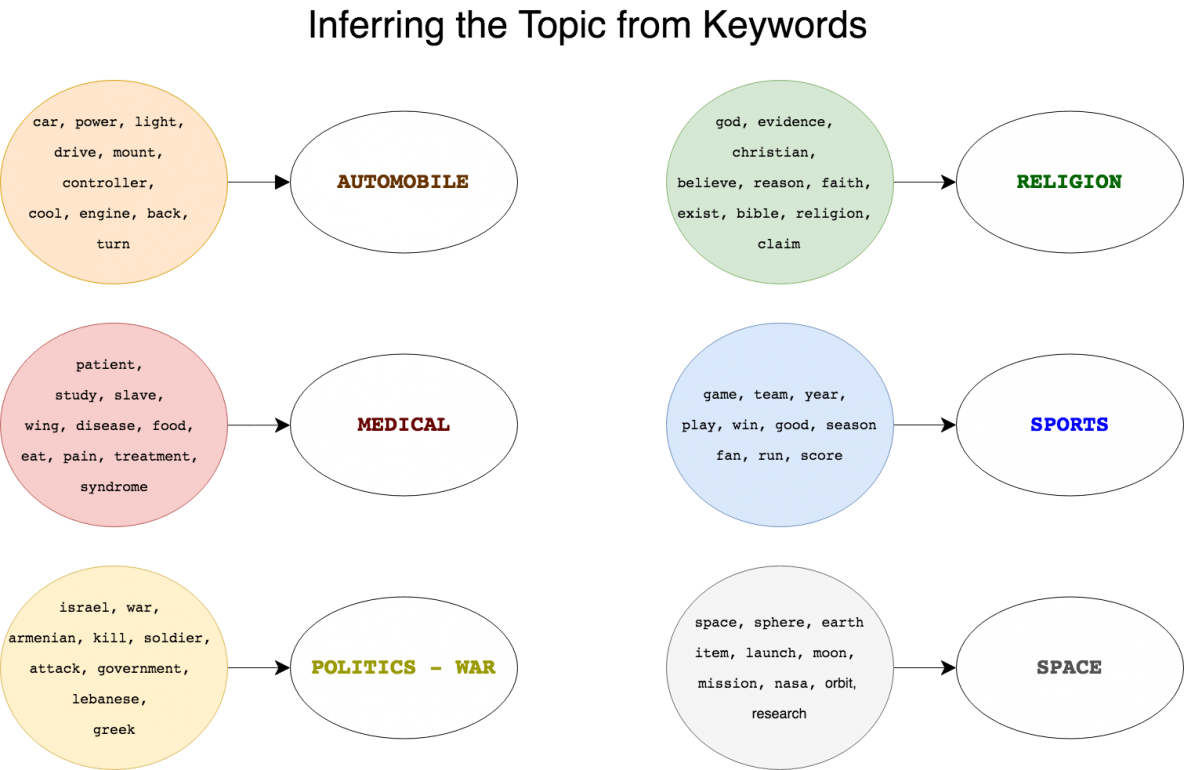

Inferring Topic from Keywords

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 14. Compute Model Perplexity and Coherence Score</h2>
</div>


Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=directions_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.417118121934791

Coherence Score:  0.4091921097800822


There you have a coherence score of 0.44.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 15. Visualize the topics-keywords</h2>
</div>

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.266663 -0.046734       1        1  19.381241
11    -0.301111 -0.104951       2        1  18.552651
6     -0.301481  0.052063       3        1  13.781644
16    -0.085641  0.312423       4        1   8.776760
3     -0.059547  0.063446       5        1   8.072317
5     -0.131586  0.107143       6        1   6.376326
4     -0.013784  0.037994       7        1   4.398666
13    -0.005950 -0.098906       8        1   3.666217
14    -0.091653 -0.201529       9        1   3.276885
2      0.103779  0.024884      10        1   2.216248
12     0.113129  0.016896      11        1   1.792120
15     0.072558  0.232158      12        1   1.786338
17    -0.025620 -0.130981      13        1   1.723012
18     0.137656 -0.010169      14        1   1.344289
8      0.069278 -0.178282      15        1   1.309505
0      0.114982 -0.002434      16        1   1.182166
10     0.145765 -0.015032      17        1   0.898477
19     0.159735  0.000253      18        1   0.773710
9      0.169085 -0.024793      19        1   0.683179
7      0.197070 -0.033448      20        1   0.008251, topic_info=        Term          Freq         Total Category  logprob  loglift
170      mix   6387.000000   6387.000000  Default  30.0000  30.0000
1       bake   6644.000000   6644.000000  Default  29.0000  29.0000
0        add  12963.000000  12963.000000  Default  28.0000  28.0000
22      heat   7830.000000   7830.000000  Default  27.0000  27.0000
5     cheese   3147.000000   3147.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
25     layer      0.005535    991.515465  Topic20  -8.8012  -2.6933
26      melt      0.005535   1947.590279  Topic20  -8.8012  -3.3684
27      milk      0.005535   2114.293890  Topic20  -8.8012  -3.4505
28    minute      0.005535  12077.844986  Topic20  -8.8012  -5.1932
29   mixture      0.005535   5130.980830  Topic20  -8.8012  -4.3371

[839 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
457       2  0.993093    absorb
0         1  0.299297       add
0         2  0.700648       add
164       5  0.998324     allow
486       1  0.996869    almond
...     ...       ...       ...
338       4  0.998783      wrap
678      13  0.997684     yeast
163       1  0.997495      yolk
716      10  0.991823      zest
466      10  0.997496  zucchini

[690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 12, 7, 17, 4, 6, 5, 14, 15, 3, 13, 16, 18, 19, 9, 1, 11, 20, 10, 8])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 16. Building LDA Mallet Model</h2>
</div>

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet's LDA from within gensim itself. You only need to [download](http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip) the zipfile, unzip it and provide the path to mallet in the unzipped directory to `gensim.models.wrappers.LdaMallet`. See how I have done this below.

In [47]:
import os
os.environ.update({'MALLET_HOME':r'C:/Users/Lenovo/Desktop/mallet-2.0.8'})

In [54]:
id2word

In [53]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/joaquingomez/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamodel = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

AttributeError: module 'gensim.models' has no attribute 'wrappers'

In [85]:
corpus

[[(0, 2),
  (1, 3),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 3),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 3),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 5),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 4),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 3),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 4),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 3),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 2),
  (56, 2),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(0, 4),
  (1, 1),
  (5, 2),
  (6, 2),
  (8, 2),
  (10, 2),
  (13, 1),
  (20, 1),
  (22, 1),
  (23, 1),
  (26, 1),
  (28, 4),
  (32, 2),
  (33, 1),
  (38, 1),
  (40, 1),
  (53, 1),
  (55, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 2),
  (71, 1),
  (72, 1),
  (73, 2),
  

In [56]:
ldamodel = gensim.models.LdaModel(corpus, num_topics=10)

In [89]:
pprint(lda_model.print_topics())

[(0,
  '0.263*"grease" + 0.241*"cake" + 0.094*"nuts" + 0.083*"margarine" + '
  '0.066*"loaf" + 0.061*"glaze" + 0.044*"pan" + 0.024*"bone" + 0.024*"tin" + '
  '0.014*"pam"'),
 (1,
  '0.054*"mixture" + 0.046*"sugar" + 0.045*"add" + 0.042*"egg" + '
  '0.042*"butter" + 0.035*"bowl" + 0.034*"cool" + 0.033*"cream" + '
  '0.033*"combine" + 0.031*"flour"'),
 (2,
  '0.141*"juice" + 0.086*"leave" + 0.084*"teaspoon" + 0.052*"ground" + '
  '0.049*"peel" + 0.045*"fresh" + 0.045*"puree" + 0.045*"lime" + 0.037*"mash" '
  '+ 0.036*"want"'),
 (3,
  '0.059*"make" + 0.039*"put" + 0.038*"use" + 0.037*"piece" + 0.026*"time" + '
  '0.022*"taste" + 0.020*"allow" + 0.018*"little" + 0.018*"keep" + '
  '0.016*"take"'),
 (4,
  '0.326*"mix" + 0.193*"ingredient" + 0.160*"well" + 0.136*"together" + '
  '0.029*"dress" + 0.023*"put" + 0.023*"serve" + 0.021*"combine" + 0.020*"do" '
  '+ 0.016*"cracker"'),
 (5,
  '0.234*"bake" + 0.118*"oven" + 0.089*"minute" + 0.070*"dish" + '
  '0.069*"preheat" + 0.056*"sheet" + 0.052

In [88]:
pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('0', 0.033281904),
   ('22', 0.025626449),
   ('28', 0.024088051),
   ('178', 0.018513637),
   ('11', 0.01830354),
   ('127', 0.015812987),
   ('186', 0.014419704),
   ('107', 0.013796022),
   ('340', 0.013458534),
   ('45', 0.013426149)]),
 (1,
  [('158', 0.018931275),
   ('29', 0.018594367),
   ('136', 0.016617732),
   ('55', 0.016604064),
   ('131', 0.0144994),
   ('51', 0.014314373),
   ('10', 0.014179699),
   ('170', 0.011269594),
   ('0', 0.011015165),
   ('45', 0.010941979)]),
 (2,
  [('1', 0.0383537),
   ('33', 0.034500554),
   ('28', 0.025214516),
   ('5', 0.021303724),
   ('191', 0.020359214),
   ('55', 0.018478883),
   ('118', 0.017653106),
   ('38', 0.017508697),
   ('48', 0.014713247),
   ('50', 0.013435464)]),
 (3,
  [('1', 0.034737483),
   ('28', 0.027394963),
   ('70', 0.02533192),
   ('0', 0.02269758),
   ('73', 0.02097489),
   ('170', 0.018248329),
   ('158', 0.014983518),
   ('33', 0.014822318),
   ('153', 0.013850966),
   ('83', 0.013382018)]),
 (4,
  [('28

In [63]:
# Show Topics
pprint(ldamodel.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamodel, texts=directions_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('0', 0.033281904),
   ('22', 0.025626449),
   ('28', 0.024088051),
   ('178', 0.018513637),
   ('11', 0.01830354),
   ('127', 0.015812987),
   ('186', 0.014419704),
   ('107', 0.013796022),
   ('340', 0.013458534),
   ('45', 0.013426149)]),
 (1,
  [('158', 0.018931275),
   ('29', 0.018594367),
   ('136', 0.016617732),
   ('55', 0.016604064),
   ('131', 0.0144994),
   ('51', 0.014314373),
   ('10', 0.014179699),
   ('170', 0.011269594),
   ('0', 0.011015165),
   ('45', 0.010941979)]),
 (2,
  [('1', 0.0383537),
   ('33', 0.034500554),
   ('28', 0.025214516),
   ('5', 0.021303724),
   ('191', 0.020359214),
   ('55', 0.018478883),
   ('118', 0.017653106),
   ('38', 0.017508697),
   ('48', 0.014713247),
   ('50', 0.013435464)]),
 (3,
  [('1', 0.034737483),
   ('28', 0.027394963),
   ('70', 0.02533192),
   ('0', 0.02269758),
   ('73', 0.02097489),
   ('170', 0.018248329),
   ('158', 0.014983518),
   ('33', 0.014822318),
   ('153', 0.013850966),
   ('83', 0.013382018)]),
 (4,
  [('28

Just by changing the LDA algorithm, we increased the coherence score from .448 to .54. Not bad!

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 17. How to find the optimal number of topics for LDA?</h2>
</div>

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The `compute_coherence_values()` (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=directions_lemmatized, start=2, limit=40, step=6)

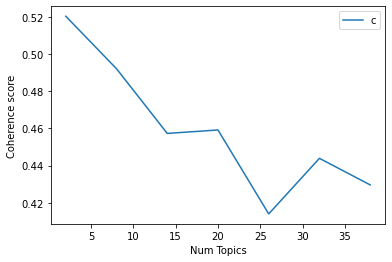

In [65]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5203
Num Topics = 8  has Coherence Value of 0.492
Num Topics = 14  has Coherence Value of 0.4573
Num Topics = 20  has Coherence Value of 0.4591
Num Topics = 26  has Coherence Value of 0.414
Num Topics = 32  has Coherence Value of 0.4439
Num Topics = 38  has Coherence Value of 0.4296


In [68]:
model_list[1]

In [76]:
model_list[7]

IndexError: list index out of range

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [77]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.024*"1" + 0.024*"28" + 0.021*"0" + 0.017*"170" + 0.014*"158" + '
  '0.013*"131" + 0.013*"29" + 0.012*"139" + 0.012*"73" + 0.012*"33"'),
 (1,
  '0.032*"0" + 0.025*"28" + 0.023*"22" + 0.019*"11" + 0.016*"51" + 0.013*"45" '
  '+ 0.012*"34" + 0.012*"32" + 0.012*"44" + 0.011*"127"')]


Those were the topics for the chosen LDA model.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 18. Finding the dominant topic in each sentence</h2>
</div>

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [78]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/var/folders/lr/qnwnf95n50n_nvvpsz8n0xk40000gn/T/ipykernel_67867/2479197559.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/lr/qnwnf95n50n_nvvpsz8n0xk40000gn/T/ipykernel_67867/2479197559.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             1.0              0.9495   
1            1             0.0              0.5015   
2            2             1.0              0.9871   
3            3             0.0              0.9929   
4            4             0.0              0.9816   
5            5             1.0              0.9706   
6            6             0.0              0.9435   
7            7             1.0              0.6019   
8            8             1.0              0.6406   
9            9             1.0              0.6644   

                                   Keywords  \
0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   
1  1, 28, 0, 170, 158, 131, 29, 139, 73, 33   
2    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   
3  1, 28, 0, 170, 158, 131, 29, 139, 73, 33   
4  1, 28, 0, 170, 158, 131, 29, 139, 73, 33   
5    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   
6  1, 28, 0, 170, 158, 131, 29, 139, 73, 33   
7    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   
8    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   
9    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   

                                                Text  
0  From: (where s my thing) Subject: WHAT car is ...  
1  From: (Guy Kuo) Subject: SI Clock Poll - Final...  
2  From: (Thomas E Willis) Subject: PB questions....  
3  From: (Joe Green) Subject: Re: Weitek P9000 ? ...  
4  From: (Jonathan McDowell) Subject: Re: Shuttle...  
5  From: (Foxvog Douglas) Subject: Re: Rewording ...  
6  From: (brian manning delaney) Subject: Brain T...  
7  From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...  
8  From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...  
9  From: (Stan Kerr) Subject: Re: Sigma Designs D...

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 19. Find the most representative document for each topic</h2>
</div>

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!



In [79]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib                                  Keywords  \
0        0.0              0.9989  1, 28, 0, 170, 158, 131, 29, 139, 73, 33   
1        1.0              0.9970    0, 28, 22, 11, 51, 45, 34, 32, 44, 127   

                                                Text  
0  From: (Jim Perry) Subject: Re: The Inimitable ...  
1  From: (Don M. Gibson) Subject: Re: Why not giv...

The tabular output above had 20 rows, one each for a topic. It has the topic number, the keywords and the most representative document. The `Perc_Contribution` column is nothing but the percentage contribution of the topic in the given document.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 20. Topic distribution across documents</h2>
</div>

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [80]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

Dominant_Topic                            Topic_Keywords  Num_Documents  \
0.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127         4490.0   
1.0              0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33         5510.0   
2.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
3.0              0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
4.0              0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
5.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
6.0              0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
7.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
8.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
9.0              1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
10.0             0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
11.0             0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
12.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
13.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
14.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
15.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
16.0             0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
17.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   
18.0             0.0  1, 28, 0, 170, 158, 131, 29, 139, 73, 33            NaN   
19.0             1.0    0, 28, 22, 11, 51, 45, 34, 32, 44, 127            NaN   

      Perc_Documents  
0.0            0.449  
1.0            0.551  
2.0              NaN  
3.0              NaN  
4.0              NaN  
5.0              NaN  
6.0              NaN  
7.0              NaN  
8.0              NaN  
9.0              NaN  
10.0             NaN  
11.0             NaN  
12.0             NaN  
13.0             NaN  
14.0             NaN  
15.0             NaN  
16.0             NaN  
17.0             NaN  
18.0             NaN  
19.0             NaN

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 21. Conclusion</h2>
</div>

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

Edit: I see some of you are experiencing errors while using the LDA Mallet and I don’t have a solution for some of the issues. So, I’ve implemented a workaround and more useful [topic model visualizations](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/). Hope you will find it helpful.

### All Rights Reserved. This notebook is proprietary content of machinelearningplus.com. This can be shared solely for educational purposes, with due credits to machinelearningplus.com